<a href="https://colab.research.google.com/github/rainidhi12/APML-Assignments/blob/main/Assgnment%205/Image_Classification_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5(i) using Pytorch
# Nidhi
# MDS202222

# Importing all required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Data


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/Assignment-5/train'
test_dir = '/content/drive/My Drive/Assignment-5/test1'
val_dir = '/content/drive/My Drive/Assignment-5/val'


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create a dictionary for the directories
data_dirs = {'train': train_dir, 'val': val_dir, 'test': test_dir}

# Create your datasets
image_datasets = {x: datasets.ImageFolder(data_dirs[x], data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Create your dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

# Get the dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Get the class names
class_names = image_datasets['train'].classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


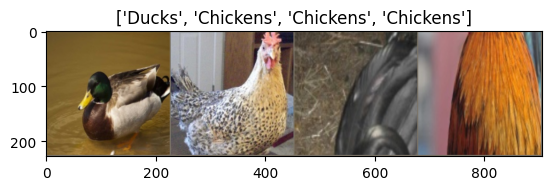

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the ConvNet


In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.3MB/s]


### Train and evaluate


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4848 Acc: 0.7381
val Loss: 0.0555 Acc: 0.9800

Epoch 1/24
----------
train Loss: 0.3769 Acc: 0.8393
val Loss: 0.0706 Acc: 0.9800

Epoch 2/24
----------
train Loss: 0.3944 Acc: 0.8512
val Loss: 0.0346 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3746 Acc: 0.8452
val Loss: 0.2031 Acc: 0.9400

Epoch 4/24
----------
train Loss: 0.3635 Acc: 0.8333
val Loss: 0.0781 Acc: 0.9200

Epoch 5/24
----------
train Loss: 0.3049 Acc: 0.8631
val Loss: 0.1513 Acc: 0.9600

Epoch 6/24
----------
train Loss: 0.5691 Acc: 0.7917
val Loss: 0.0824 Acc: 0.9600

Epoch 7/24
----------
train Loss: 0.3729 Acc: 0.8869
val Loss: 0.0507 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.3226 Acc: 0.8690
val Loss: 0.0478 Acc: 0.9800

Epoch 9/24
----------
train Loss: 0.3377 Acc: 0.8869
val Loss: 0.0509 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8690
val Loss: 0.0532 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.3395 Acc: 0.8571
val Loss: 0.0588 Acc: 0.9800

Ep

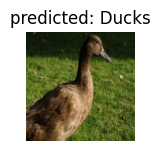

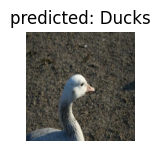

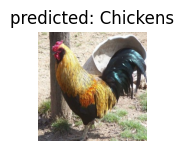

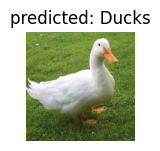

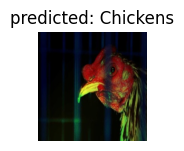

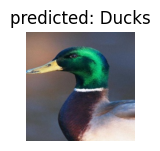

In [ ]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6733 Acc: 0.5952
val Loss: 0.1178 Acc: 0.9600

Epoch 1/24
----------
train Loss: 0.3792 Acc: 0.8036
val Loss: 0.0641 Acc: 0.9800

Epoch 2/24
----------
train Loss: 0.2767 Acc: 0.8869
val Loss: 0.0482 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3648 Acc: 0.8214
val Loss: 0.0534 Acc: 0.9800

Epoch 4/24
----------
train Loss: 0.3455 Acc: 0.8571
val Loss: 0.0682 Acc: 0.9600

Epoch 5/24
----------
train Loss: 0.2909 Acc: 0.8869
val Loss: 0.1035 Acc: 0.9400

Epoch 6/24
----------
train Loss: 0.2567 Acc: 0.8631
val Loss: 0.0364 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3553 Acc: 0.8452
val Loss: 0.0937 Acc: 0.9600

Epoch 8/24
----------
train Loss: 0.2555 Acc: 0.8810
val Loss: 0.0333 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2071 Acc: 0.9167
val Loss: 0.0338 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.2810 Acc: 0.8988
val Loss: 0.0392 Acc: 0.9800

Epoch 11/24
----------
train Loss: 0.1637 Acc: 0.9345
val Loss: 0.0549 Acc: 0.9600

Ep

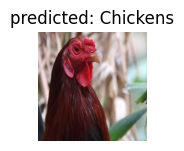

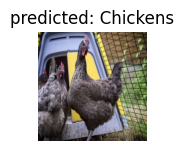

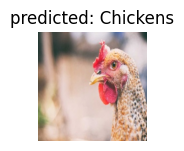

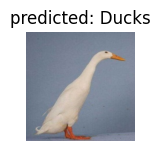

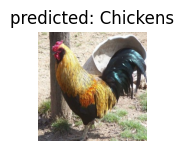

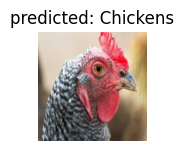

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()